# Smooth Dynamic Morphing

In this notebook I will show how to do smooth dynamic morphing using 2 orthogonal bases on coupling coefficients for VBF data.

The morphing algorithm works as follows:
 1. Select randomly **ncomb** samples from all samples
 2. Obtain all permutations of **nsamples** size from the **ncomb** samples
 3. Sort the obtained permutations by evaluating **n_eff/n_tot** ratio on a representative point of the fitting space (the central point is fine) and retain a X%(using 50%) of the best permutations.
 4. For each permutation choose randomly **n_2** bases as a possible second base using the rest of the samples, (base_1,base_2_1),(base_1,base_2_1),...,(base_1,base_2_n_2),(base_2,base_2_1),...(base_n_1,base_2_n_2).
 5. At this point depending in the amount of pairs obtained I throw away randomly a X% of the pairs.
 6. Select the best pair of bases evaluating each pair as $\sum_{(c1,c2)\in C1XC2} (n\_eff\_1(c1,c2) + n\_eff\_2(c1,c2))/2$ where $n\_eff\_i(c1,c2)$ are the values of the **n_eff** ratio for the base i and evaluated in the point c1,c2 of the parameter space. Depending on the number of pairs, another option is to stop the search as soon as a defined value is reached. Also, if any of the points evaluated in the previous sum have a **condition number** too small then both bases are rejected.
 
Something to notice is that in python (itertools) the permutations are evaluated in a lazy way, so when I say 'Obtain all the permutations' they are not really computed (put in memory).

I will show how to use the class implemented to do the **smooth morphing**, this code makes use of the EFT Morphing code. A python Wrapper for this code have been implemented.

In [1]:

import numpy as np
import pdb 
from pyMorphWrapper import MorphingWrapper

In [2]:
%matplotlib inline


We start by defining some constants:
- The fitting range
- The number of points in the coupling space to be used in the fit
- The available samples

In [3]:
# Define fitting ranges
g1_range = (0.1,0.9)
g2_range = (0.1,0.9)

# Intervals for each axis
npoints = 15

csarray1 = np.linspace(g1_range[0],g1_range[1],npoints)
csarray2 = np.linspace(g2_range[0], g2_range[1], npoints)


# nsamples, ncomb
nsamples = 15
ncomb = 18
# List of availables basis samples
available_samples = [[1.0, 1.0, 0.5], [1.0, 0.0, -1.0], [1.0, 0.0, -0.5], [1.0, 1.0, 0.0], [1.0, 1.0, 1.0], 
                     [1.0, 1.0, -0.5], [1.0, 0.5, 0.3333333333333333], [1.0, 0.3333333333333333, 0.2], 
                     [1.0, 0.3333333333333333, 0.14285714285714285], [1.0, 0.25, 0.16666666666666666], 
                     [1.0, 2.0, 0.0], [1.0, 2.0, 1.0], [1.0, 2.0, 2.0], [1.0, 2.0, -1.0], [1.0, -1.0, 0.0],
                     [1.0, -1.0, 0.5], [1.0, -1.0, -0.5], [1.0, -0.5, -0.3333333333333333], 
                     [1.0, -0.3333333333333333, -0.2], [1.0, -0.3333333333333333, -0.14285714285714285], 
                     [1.0, -0.25, -0.16666666666666666], [1.0, -2.0, 0.0], [1.0, -2.0, 1.0], [1.0, -2.0, -1.0], 
                     [1.0, -2.0, -2.0], [1.0, -1.5, -1.5]]

Now we use the morphing class and set the data used in the morphing.

In [6]:
# Compute both bases
morph = MorphingWrapper()
# Define number of samples, number of couplings, types (S,P,D) and available samples
# Using half of range as initial target (used only to make computation faster)
target = [1.,0.5,0.5]
morph.setSampleData(nsamples=nsamples,ncouplings=3,types=['S','S','S'],samples=available_samples,
      ncomb=ncomb)
# Obtain the bases by using smooth dynamic morphing

In [7]:
# Obtain the bases by using smooth dynamic morphing
indexes = morph.dynamicMorphing(cvalues_1 = csarray1,cvalues_2 = csarray2)

Starting combinations
Start sorting
Elapsed time combinations: 0.215083122253
Number of combinations: 122
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Elapsed time 2nd basis: 19.394944191
Results on target for each basis: 
Result: 0.226614983089 ,Det: -0.00116711843293, Cond: 17679.6113281
Result: 0.0249588355174 ,Det: -137769.84375, Cond: 49836.0117188


In [8]:
print indexes

[(8, 2, 3, 1, 19, 6, 5, 9, 23, 11, 24, 21, 15, 12, 10), (0, 7, 13, 14, 16, 17, 18, 20, 22, 25, 8, 2, 3, 1, 9)]


Next we obtain the cross sections and weights for each one of the orthogonal bases and for each point on the parameter space.

In [9]:
# Save cross sections and couplings for each one of the points on the fitting space
# Also compute the weighted n_eff
for l,ind in enumerate(indexes): 
  ind = np.array(ind)
  morph.resetBasis([available_samples[int(k)] for k in ind]) 
  sorted_indexes = np.argsort(ind)
  indexes[l] = ind[sorted_indexes]
  for i,cs in enumerate(csarray1):
    for j,cs2 in enumerate(csarray2):
      target[1] = cs
      target[2] = cs2 
      morph.resetTarget(target)
        # Compute weights and cross section of each sample
      couplings = np.array(morph.getWeights())
      cross_section = np.array(morph.getCrossSections())
      couplings,cross_section = (couplings[sorted_indexes],
                        cross_section[sorted_indexes])
      # Save list of cross sections and weights for each samples and orthogonal bases
      all_couplings = np.vstack([all_couplings,couplings])  if i <> 0 or j <> 0 or l <> 0 else couplings
      all_cross_sections = np.vstack([all_cross_sections, cross_section]) if i <> 0 or j <> 0 or l <> 0 else cross_section

Finally, we compute the weighted n_eff for each point in the parameter space

In [10]:
# Now compute and plot the weighted n_eff in order to evaluate the models
alpha = np.zeros([csarray1.shape[0],csarray2.shape[0],2])
n_eff_ratio = np.zeros((csarray1.shape[0], csarray2.shape[0]))
for i,cs in enumerate(csarray1):
  for j, cs2 in enumerate(csarray2):
    target[1] = cs
    target[2] = cs2
    print '{0} {1}'.format(i,j)
    print target

    c1s_1 = all_couplings[i*npoints + j]
    cross_section_1 = all_cross_sections[i*npoints + j]
    c1s_1 = np.multiply(c1s_1,cross_section_1)
    n_eff = c1s_1.sum()
    n_tot = np.abs(c1s_1).sum()
    n_eff_1 = n_eff / n_tot

    c1s_2 = all_couplings[npoints*npoints + i*npoints + j]
    cross_section_2 = all_cross_sections[npoints*npoints + i*npoints + j]
    c1s_2 = np.multiply(c1s_2,cross_section_2)
    n_eff = c1s_2.sum()
    n_tot = np.abs(c1s_2).sum()
    n_eff_2 = n_eff / n_tot

    # Compute weights for bases
    neff2 = 1./n_eff_2
    neff1 = 1./n_eff_1
    alpha1 = np.exp(-np.sqrt(neff1))
    alpha2 = np.exp(-np.sqrt(neff2))
    alpha[i,j,0] = alpha1/(alpha1 + alpha2)
    alpha[i,j,1] = alpha2/(alpha1 + alpha2)

    # Compute Bkg weights
    n_eff_ratio[i,j] = (alpha[i,j,0]*n_eff_1 + alpha[i,j,1]*n_eff_2)

    print 'Weighted eff for ({0},{1}): {2}'.format(cs,cs2,n_eff_ratio[i,j])

0 0
[1.0, 0.10000000000000001, 0.10000000000000001]
Weighted eff for (0.1,0.1): 0.129105245211
0 1
[1.0, 0.10000000000000001, 0.15714285714285714]
Weighted eff for (0.1,0.157142857143): 0.0813242364876
0 2
[1.0, 0.10000000000000001, 0.2142857142857143]
Weighted eff for (0.1,0.214285714286): 0.063274407421
0 3
[1.0, 0.10000000000000001, 0.27142857142857146]
Weighted eff for (0.1,0.271428571429): 0.0502617899014
0 4
[1.0, 0.10000000000000001, 0.32857142857142863]
Weighted eff for (0.1,0.328571428571): 0.0444703161662
0 5
[1.0, 0.10000000000000001, 0.38571428571428579]
Weighted eff for (0.1,0.385714285714): 0.0411524519799
0 6
[1.0, 0.10000000000000001, 0.44285714285714284]
Weighted eff for (0.1,0.442857142857): 0.038988742279
0 7
[1.0, 0.10000000000000001, 0.5]
Weighted eff for (0.1,0.5): 0.0365452653161
0 8
[1.0, 0.10000000000000001, 0.55714285714285716]
Weighted eff for (0.1,0.557142857143): 0.0348290378812
0 9
[1.0, 0.10000000000000001, 0.61428571428571432]
Weighted eff for (0.1,0.614

[]

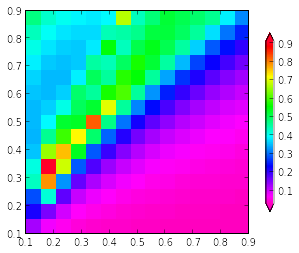

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
vals = np.flipud(n_eff_ratio)
im = plt.imshow(vals, extent=(csarray2.min(), csarray2.max(), csarray1.min(),csarray1.max()),interpolation='nearest', cmap=cm.gist_rainbow_r)
CB = plt.colorbar(im, shrink=0.8, extend='both')
plt.plot()
                 